In [2]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output
from siuba import _, mutate, case_when, filter, group_by, summarize, select, arrange, spread
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import requests

df = pd.read_csv("./origin_destination_train_202212.csv")
services = pd.read_csv("./bus_services.csv")
routes = pd.read_csv("./bus_routes.csv")

## Data Collection
API

In [3]:
stations = df["ORIGIN_PT_CODE"].unique()
stations = [x for x in stations if len(x)<=5] # remove multi mrts

# use api to request onemap for coordinates of station
final = []
for i in stations:
    station_code = i

    url = "https://developers.onemap.sg/commonapi/search?searchVal={}&returnGeom=Y&getAddrDetails=N&pageNum=1".format(station_code)
    response = requests.get(url)

    if response.status_code == 200:
        result = response.json()
        if result['found'] > 0:
            latitude = result['results'][0]['LATITUDE']
            longitude = result['results'][0]['LONGITUDE']
            temp = {"latitude":latitude,"longitude":longitude,"station":i}
            final.append(temp)
        else:
            print(i)
    else:
        print("Request failed with status code:", response.status_code,i)
locations = pd.DataFrame(final)

## Bus Data Wrangling

In [4]:
## Cleaning, some values i searched up online manually
routes.loc[routes.index == 8103, 'Distance'] = 0
routes.loc[routes.index == 8139, 'Distance'] = 0
routes.loc[routes.index == 9726, 'Distance'] = 0
routes.loc[routes.index == 11789, 'Distance'] = 0
routes.loc[routes.index == 10898, 'Distance'] = 15.2
routes = routes[routes["BusStopCode"]!="E0323"]
services = services.drop(index=510,axis=0)
services = services.drop(index=569,axis=0)

# find number of stops a bus stopped at
stops = (routes
        >>group_by(_.ServiceNo,_.Direction)
        >>summarize(totalStops=_.Distance.count())
        )

services = services.merge(stops,how="left",on=["ServiceNo","Direction"])

## Bus Data Analysis
### Objective
- Singapore government has given a 200 million susidy to bus operators. Source: https://www.mot.gov.sg/news/details/additional-200m-support-from-government-to-mitigate-the-impact-of-fare-increase-on-commuters I want to know what is the best way to split this based on factors below
### Aims for Graphs:
- Find which operator offers more variety of bus services to people
- Find which operator has more buses overall
- Find which operator services more bus stops, helping connect singapore

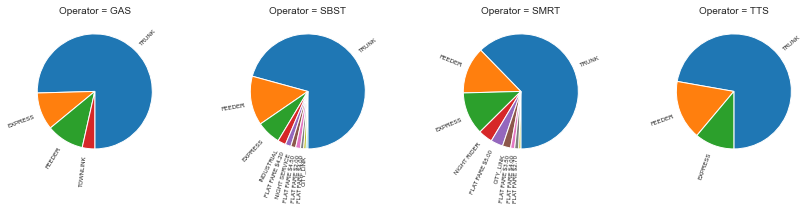

In [5]:
sns.set_style("darkgrid")
g = sns.FacetGrid(data=services, col="Operator")
def pie(data, **kwargs):
    data = data['Category'].value_counts()
    plt.pie(data, labels=data.index,startangle=270,textprops={'fontsize': 6},rotatelabels=True)
g.map_dataframe(pie)
plt.show()

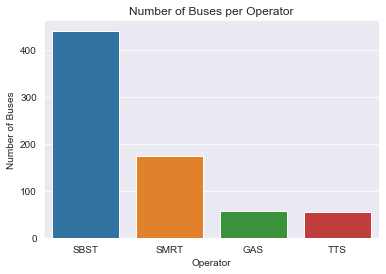

In [6]:
sns.set_style("darkgrid")
sns.barplot(x=services['Operator'].value_counts().index, y=services['Operator'].value_counts().values)
plt.xlabel('Operator')
plt.ylabel('Number of Buses')
plt.title("Number of Buses per Operator")
plt.show()

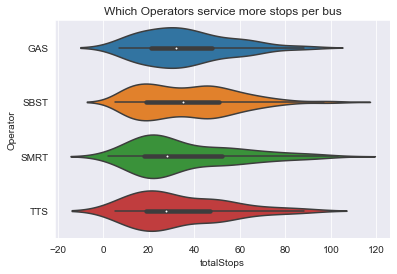

In [7]:
sns.set_style("darkgrid")
sns.violinplot(data=services, x="totalStops", y="Operator")
plt.title("Which Operators service more stops per bus")
plt.show()

## Train Data Wrangling

In [8]:
# i indetified some groups of stations where the people using will benefit from the new train lines
def groupCreate(line,range):
    temp = df[["ORIGIN_PT_CODE","DESTINATION_PT_CODE"]].copy()
    temp = (temp
        >> select(_.ORIGIN_PT_CODE)
        >> filter(_.ORIGIN_PT_CODE.str.startswith(line),_.ORIGIN_PT_CODE.str.len()<=5)
        >> mutate(nums = _.ORIGIN_PT_CODE.str.removeprefix(line).astype(int))
        >> arrange(_.nums)
        >> filter(_.nums>range[0],_.nums <range[1])
    )   
    return temp["ORIGIN_PT_CODE"].unique()   
# i dont want to type 30 mrt lines manually so i wrote this
grp1 = groupCreate("CC",[24,30])
grp2 = np.array(["NS27","NS28","TE22"],dtype=object)
grp3 = np.append(groupCreate("DT",[32,38]),"CG2")
grp4 = np.append(grp2, ["TE18","TE19"])
grp5 = np.concatenate((groupCreate("SE",[0,29]),groupCreate("SW",[0,29]), groupCreate("PE",[0,29]), groupCreate("PW",[0,29]), groupCreate("NE",[12,18])), axis=None)
grp6 = np.concatenate((groupCreate("CG",[0,3]), groupCreate("DT",[30,38])), axis=None)
grp7 = groupCreate("EW",[22,34])
grp8 = groupCreate("DT",[0,7])
grp9 = groupCreate("TE",[0,8])

In [9]:
# I paired up the groups to analyse them in groups, refer to slides
locations2 = (locations
    >> select(-_["Unnamed: 0"])
    >> mutate(line = _.station.str[:2])
)
locations2["latitude"] = locations2["latitude"].astype(float)
locations2["longitude"] = locations2["longitude"].astype(float)
grp1a = locations2 >> filter((_.station.isin(grp1))|(_.station.isin(grp2)))
grp2a = locations2 >> filter((_.station.isin(grp3))|(_.station.isin(grp4)))
grp3a = locations2 >> filter((_.station.isin(grp6))|(_.station.isin(grp5)))
grp4a = locations2 >> filter((_.station.isin(grp8))|(_.station.isin(grp7)))
grp5a = locations2 >> filter((_.station.isin(grp9))|(_.station.isin(grp8)))
grp6a = locations2 >> filter((_.station.isin(grp5))|(_.station.isin(grp9)))
groups = [0,grp1a,grp2a,grp3a,grp4a,grp5a,grp6a]
locations2.dtypes

latitude     float64
longitude    float64
station       object
line          object
dtype: object

In [10]:
def timeCalc(oriArr,destArr):
    temp = df.copy()
    temp1 = (temp
            >> filter(_.ORIGIN_PT_CODE.isin(oriArr))
            >> filter(_.DESTINATION_PT_CODE.isin(destArr))
    )
    temp2 = (temp
            >> filter(_.ORIGIN_PT_CODE.isin(destArr))
            >> filter(_.DESTINATION_PT_CODE.isin(oriArr))
    )
    temp3 = pd.concat([temp1,temp2])
    temp3 = (temp3
             >> select(_.TOTAL_TRIPS,_.TIME_PER_HOUR)
             >> group_by(_.TIME_PER_HOUR)
             >> summarize(total=_.TOTAL_TRIPS.sum())
             )
    return temp3
x1 = timeCalc(grp1,grp2)
x1["pair"] = 1
x2 = timeCalc(grp3,grp4)
x2["pair"] = 2
x3 = timeCalc(grp5,grp6)
x3["pair"] = 3
x4 = timeCalc(grp7,grp8)
x4["pair"] = 4
x5 = timeCalc(grp8,grp9)
x5["pair"] = 5
x6 = timeCalc(grp5,grp9)
x6["pair"] = 6
dashData = pd.concat((x1,x2,x3,x4,x5,x6),ignore_index=True)
dashData = dashData.sort_values(["pair","TIME_PER_HOUR"])

In [11]:
def totalCalc(oriArr,destArr):
    temp = df.copy()
    temp1 = (temp
            >> filter(_.ORIGIN_PT_CODE.isin(oriArr))
            >> filter(_.DESTINATION_PT_CODE.isin(destArr))
    )
    temp2 = (temp
            >> filter(_.ORIGIN_PT_CODE.isin(destArr))
            >> filter(_.DESTINATION_PT_CODE.isin(oriArr))
    )
    return temp1["TOTAL_TRIPS"].sum()+temp2["TOTAL_TRIPS"].sum()
p1 = {"sum":totalCalc(grp1,grp2),"pair":1}
p2 = {"sum":totalCalc(grp3,grp4),"pair":2}
p3 = {"sum":totalCalc(grp5,grp6),"pair":3}
p4 = {"sum":totalCalc(grp7,grp8),"pair":4}
p5 = {"sum":totalCalc(grp8,grp9),"pair":5}
p6 = {"sum":totalCalc(grp5,grp9),"pair":6}
barPlotDF = pd.DataFrame([p1,p2,p3,p4,p5,p6])

## Train Data Analysis
### Objective
- Thomson East Coast line, Cross Island Line, Circle Line finish are some lines that are being built. I want to know which parts of these lines govt. should prioritise based on how many people can benefit from it
### Aims for Graph
- Provide you with a graphical understanding of how i grouped the train stations to analyse
- Perform exploratory analysis on the data to roughly gauge the answer
- Create a interactive way for you to compare the importance of the various lines

In [12]:
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Pairs of MRTs"),
    dcc.Dropdown(
        id="drop",
        options=[
            {'label': 'All', 'value': 0},
            {'label': 'Pair 1', 'value': 1},
            {'label': 'Pair 2', 'value': 2},
            {'label': 'Pair 3', 'value': 3},
            {'label': 'Pair 4', 'value': 4},
            {'label': 'Pair 5', 'value': 5},
            {'label': 'Pair 6', 'value': 6},
        ],
        multi=False,
        value=0
    ),
    dcc.Graph(id="map", figure={})
])
@app.callback(
    Output(component_id='map', component_property='figure'),
    Input(component_id='drop', component_property='value')
)
def update_output_div(input_value): 
    if(input_value==0):
        fig = px.scatter_mapbox(locations2, 
                        lat="latitude", 
                        lon="longitude",
                        color="line",  # reverse the scale
                        zoom=9)
        fig.update_layout(mapbox_style="carto-darkmatter")
    else:
        fig = px.scatter_mapbox(groups[input_value], 
                        lat="latitude", 
                        lon="longitude",
                        color="line",  # reverse the scale
                        zoom=9)
        fig.update_layout(mapbox_style="carto-darkmatter")
    return fig
if __name__ == '__main__':
    app.run_server() ## cannot run debug as im in jupyter node book

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


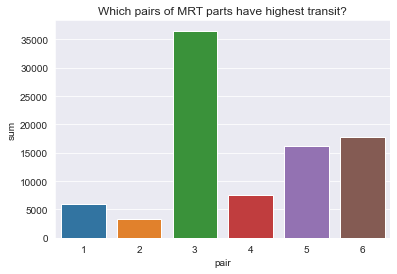

In [13]:
sns.set_style("darkgrid")
sns.barplot(data=barPlotDF, x="pair", y="sum")
plt.title("Which pairs of MRT parts have highest transit?")
plt.show()

In [14]:
app = Dash(__name__)
app.layout = html.Div([
    html.H6("Change the value in the text box to see callbacks in action!"),
    dcc.Dropdown(
        id="drop",
        options=[
            {'label': 'Pair 1', 'value': 1},
            {'label': 'Pair 2', 'value': 2},
            {'label': 'Pair 3', 'value': 3},
            {'label': 'Pair 4', 'value': 4},
            {'label': 'Pair 5', 'value': 5},
            {'label': 'Pair 6', 'value': 6},
        ],
        multi=True,
        value=[1,2]
    ),
    dcc.Graph(id="linemap", figure={})
])
@app.callback(
    Output(component_id='linemap', component_property='figure'),
    Input(component_id='drop', component_property='value')
)
def update_output_div(input_values):
    data = dashData[dashData["pair"].isin(input_values)]
    fig = px.line(data, x="TIME_PER_HOUR", y="total", title='Passengers over Time', color="pair", markers=True)
    return fig
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:06] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2023 10:35:14] "POST /_dash-update-component HTTP/1.